### Idea

Input state and data -> train against tomorrow state.

After training, generate full matrix for tomorrow by inputting all states.

Is apparently useful for inference and further finacial analysis.

It is thus time dependent.

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

In [ ]:
train_df  = pd.read_csv("dataset/train_diagnostic.csv")
labels_df = pd.read_csv("dataset/label_diagnostic.csv")

print(train_df.shape, labels_df.shape)
train_df.head()

# Rebuild forward % change from Price so that we can define bin midpoints
# Forward return at day t = (Price_{t+1} / Price_t - 1) * 100
train_df["Percent_change_forward"] = (
    train_df["Price"].shift(-1) / train_df["Price"] - 1
) * 100.0

# Drop last row where forward return is undefined
train_df = train_df.iloc[:-1].copy()
labels_df = labels_df.iloc[:-1].copy()

torch.manual_seed(42)

In [3]:
# Drop columns that contain NaNs (at least the obviously problematic ones)
cols_with_na = train_df.columns[train_df.isna().any()].tolist()
print("Columns with NaNs:", cols_with_na)

# Quick and dirty: drop all of them, or at least 'Opinion'
train_df = train_df.drop(columns=["Opinion"], errors="ignore")


drop_cols = ["index", "Percent_change_forward", "Backward_Bin"]
feature_cols = [c for c in train_df.columns if c not in drop_cols]

X_all = train_df[feature_cols].values.astype(np.float32)

# States: make them 0-based for PyTorch
s_curr_all = (train_df["Backward_Bin"].values.astype(np.int64) - 1)
y_all      = (labels_df["Forward_Bin"].values.astype(np.int64) - 1)

n_samples, n_features = X_all.shape
n_states = int(max(s_curr_all.max(), y_all.max()) + 1)

print("n_samples:", n_samples)
print("n_features:", n_features)
print("n_states:", n_states)


Columns with NaNs: ['Opinion']
n_samples: 2368
n_features: 195
n_states: 55


In [4]:
# Temporal split: 70 / 15 / 15
T = n_samples
train_end = int(0.7 * T)
val_end   = int(0.85 * T)

idx_train = np.arange(0,        train_end)
idx_val   = np.arange(train_end, val_end)
idx_test  = np.arange(val_end,  T)

def split(arr):
    return arr[idx_train], arr[idx_val], arr[idx_test]

X_train, X_val, X_test = split(X_all)
s_train, s_val, s_test = split(s_curr_all)
y_train, y_val, y_test = split(y_all)

# Standardize features based on *training* only
mean = X_train.mean(axis=0, keepdims=True)
std  = X_train.std(axis=0, keepdims=True) + 1e-8

X_train_std = (X_train - mean) / std
X_val_std   = (X_val   - mean) / std
X_test_std  = (X_test  - mean) / std

# Store for later (transition matrices on full data)
X_all_std = (X_all - mean) / std


In [5]:
class TransitionDataset(Dataset):
    def __init__(self, X, s_curr, s_next):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.s_curr = torch.tensor(s_curr, dtype=torch.long)
        self.s_next = torch.tensor(s_next, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.s_curr[idx], self.s_next[idx]

train_ds = TransitionDataset(X_train_std, s_train, y_train)
val_ds   = TransitionDataset(X_val_std,   s_val,   y_val)
test_ds  = TransitionDataset(X_test_std,  s_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=512, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=512, shuffle=False)


In [6]:
class TransitionNet(nn.Module):
    def __init__(self, n_features, n_states, hidden_dims=(64,128, 256, 128, 64), dropout=0.2):
        super().__init__()
        self.n_states = n_states

        layers = []
        in_dim = n_features + n_states  # features + one-hot state

        for h in hidden_dims:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(dropout))
            in_dim = h

        self.mlp = nn.Sequential(*layers)
        self.out = nn.Linear(in_dim, n_states)

    def forward(self, x, s_curr):
        """
        x:      (B, n_features)
        s_curr: (B,)  int state indices in [0, n_states-1]
        """
        s_onehot = F.one_hot(s_curr, num_classes=self.n_states).float()
        z = torch.cat([x, s_onehot], dim=-1)
        h = self.mlp(z)
        logits = self.out(h)
        return logits


In [7]:
device = DEVICE

model = TransitionNet(n_features=n_features, n_states=n_states).to(device)

# Class weights: inverse frequency of next-state bins
class_counts = np.bincount(y_train, minlength=n_states)
class_weights = class_counts.sum() / np.maximum(class_counts, 1)
class_weights = class_weights / class_weights.mean()  # rescale a bit
class_weights_t = torch.tensor(class_weights, dtype=torch.float32, device=device)

criterion = nn.CrossEntropyLoss(weight=class_weights_t)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)


In [8]:
def run_epoch(loader, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    total_n = 0
    total_correct = 0

    with torch.set_grad_enabled(train):
        for X_batch, s_curr_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            s_curr_batch = s_curr_batch.to(device)
            y_batch = y_batch.to(device)

            if train:
                optimizer.zero_grad()

            logits = model(X_batch, s_curr_batch)
            loss = criterion(logits, y_batch)

            if train:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

            batch_size = X_batch.size(0)
            total_loss += loss.item() * batch_size
            total_n    += batch_size

            preds = logits.argmax(dim=1)
            total_correct += (preds == y_batch).sum().item()

    return total_loss / total_n, total_correct / total_n

n_epochs = 40

train_losses_transition, val_losses_transition = [], []

for epoch in range(1, n_epochs + 1):
    train_loss, train_acc = run_epoch(train_loader, train=True)
    val_loss,   val_acc   = run_epoch(val_loader,   train=False)
    train_losses_transition.append(train_loss)
    val_losses_transition.append(val_loss)

    print(
        f"Epoch {epoch:03d} | "
        f"train loss {train_loss:.4f} acc {train_acc:.3f} | "
        f"val loss {val_loss:.4f} acc {val_acc:.3f}"
    )

test_loss, test_acc = run_epoch(test_loader, train=False)
print(f"Test loss {test_loss:.4f}, test acc {test_acc:.3f}")


Epoch 001 | train loss 4.0129 acc 0.022 | val loss 4.0074 acc 0.014
Epoch 002 | train loss 4.0122 acc 0.024 | val loss 4.0073 acc 0.014
Epoch 003 | train loss 4.0128 acc 0.032 | val loss 4.0072 acc 0.014
Epoch 004 | train loss 4.0122 acc 0.027 | val loss 4.0071 acc 0.014
Epoch 005 | train loss 4.0118 acc 0.028 | val loss 4.0069 acc 0.014
Epoch 006 | train loss 4.0112 acc 0.024 | val loss 4.0068 acc 0.020
Epoch 007 | train loss 4.0108 acc 0.024 | val loss 4.0067 acc 0.020
Epoch 008 | train loss 4.0103 acc 0.026 | val loss 4.0066 acc 0.020
Epoch 009 | train loss 4.0100 acc 0.028 | val loss 4.0065 acc 0.020
Epoch 010 | train loss 4.0089 acc 0.031 | val loss 4.0065 acc 0.020
Epoch 011 | train loss 4.0088 acc 0.027 | val loss 4.0063 acc 0.020
Epoch 012 | train loss 4.0078 acc 0.028 | val loss 4.0062 acc 0.020
Epoch 013 | train loss 4.0064 acc 0.024 | val loss 4.0061 acc 0.020
Epoch 014 | train loss 4.0031 acc 0.025 | val loss 4.0060 acc 0.020
Epoch 015 | train loss 4.0008 acc 0.024 | val lo

In [9]:
def build_transition_matrix_for_day(k):
    """
    k: integer index in [0, n_samples-1] (row in your CSV)
    returns: A_k of shape (n_states, n_states)
    """
    model.eval()
    x_k = torch.tensor(X_all_std[k], dtype=torch.float32, device=device)

    # Repeat the same features for each possible current state i
    x_rep = x_k.unsqueeze(0).repeat(n_states, 1)  # (n_states, n_features)
    s_curr_all = torch.arange(n_states, dtype=torch.long, device=device)

    with torch.no_grad():
        logits = model(x_rep, s_curr_all)         # (n_states, n_states)
        A_k = F.softmax(logits, dim=1)            # probabilities

    return A_k.cpu()  # (n_states, n_states)


In [10]:
k_example = 100  # pick a date by row index
A_k = build_transition_matrix_for_day(k_example)

print(A_k.shape)     # should be (n_states, n_states)
print(A_k.sum(dim=1))  # each row ~ 1.0


torch.Size([55, 55])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])


In [11]:
# Build model-based transition matrices A_all for all k
# A_all[k] has shape (n_states, n_states)

model.eval()

A_all_list = []

with torch.no_grad():
    for k in range(n_samples):
        A_k = build_transition_matrix_for_day(k)   # (n_states, n_states)
        A_all_list.append(A_k.unsqueeze(0))        # (1, n_states, n_states)

A_all = torch.cat(A_all_list, dim=0)               # (n_samples, n_states, n_states)
print(A_all.shape)


torch.Size([2368, 55, 55])


In [ ]:
import os

os.makedirs("transition_outputs", exist_ok=True)

# Save transition matrices
torch.save(A_all, "transition_outputs/A_all_model_diagnostic.pt")
np.save("transition_outputs/A_all_model_diagnostic.npy", A_all.numpy())

# Save model weights for comprehensive analysis
torch.save(model.state_dict(), "transition_outputs/model_weights_diagnostic.pt")

print("Saved A_all and model weights (diagnostic) to transition_outputs/")

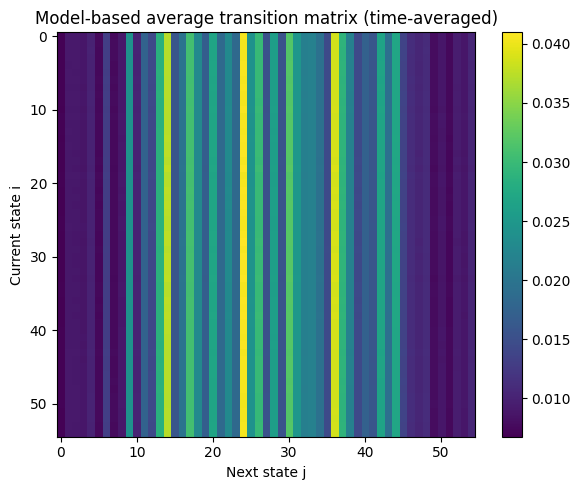

In [13]:
import matplotlib.pyplot as plt

# Average over time (k dimension)
A_mean = A_all.mean(dim=0).numpy()   # (n_states, n_states)

plt.figure(figsize=(6, 5))
im = plt.imshow(A_mean, aspect='auto')
plt.colorbar(im)
plt.xlabel("Next state j")
plt.ylabel("Current state i")
plt.title("Model-based average transition matrix (time-averaged)")
plt.tight_layout()
plt.show()


Empirical transition matrix shape: (55, 55)


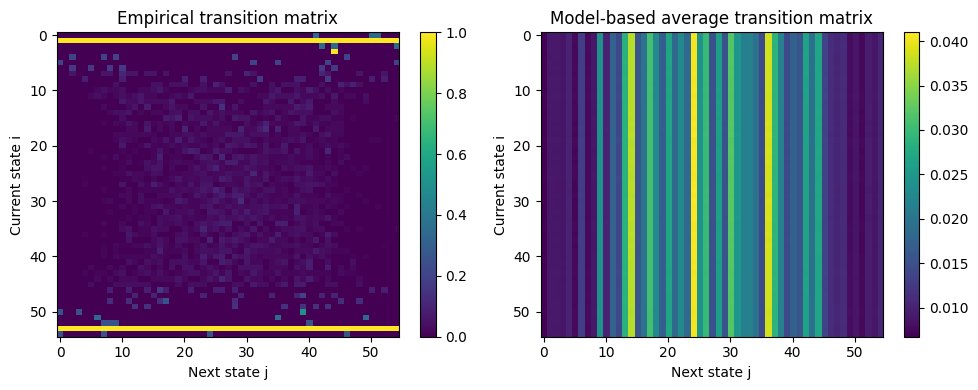

In [14]:
# You already have these:
# s_curr_all = Backward_Bin - 1
# y_all = Forward_Bin - 1
# n_states = max bin + 1

A_emp_counts = np.zeros((n_states, n_states), dtype=np.float64)

# Build counts
for i, j in zip(s_curr_all, y_all):
    A_emp_counts[i, j] += 1

# Convert to probabilities with smoothing to avoid zero-rows
A_emp = (A_emp_counts + 1e-8) / (A_emp_counts.sum(axis=1, keepdims=True) + 1e-8)

print("Empirical transition matrix shape:", A_emp.shape)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

im0 = axes[0].imshow(A_emp, aspect='auto')
axes[0].set_title("Empirical transition matrix")
axes[0].set_xlabel("Next state j")
axes[0].set_ylabel("Current state i")
fig.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(A_mean, aspect='auto')
axes[1].set_title("Model-based average transition matrix")
axes[1].set_xlabel("Next state j")
axes[1].set_ylabel("Current state i")
fig.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()


Number of states: 55
bin_midpoints length: 55
First few bin_midpoints (%): [-13.01242414   0.          -8.21251676  -7.12392988  -6.56564952
  -5.32113348  -4.77689502  -4.29346412  -3.77611626  -3.22002121]
Simulated price array shape: (10, 11)


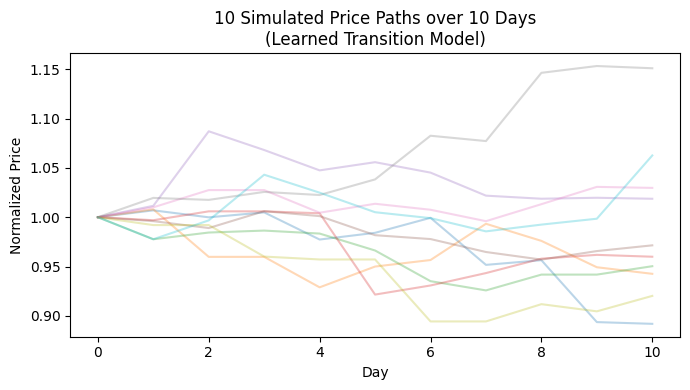

In [15]:
# ---------------------------------------------------------
# 0. BUILD BIN MIDPOINTS FROM DATA (NO GUESSING)
# ---------------------------------------------------------
# We define one representative return per state j as the
# mean of Percent_change_forward over all samples with Forward_Bin = j+1.

# Make sure these exist from earlier in the notebook:
# - train_df: DataFrame with column "Percent_change_forward"
# - labels_df: DataFrame with column "Forward_Bin"
# - y_all: 0-based next-state labels (Forward_Bin - 1)
# - n_states: number of unique states

returns_pct_all = train_df["Percent_change_forward"].values.astype(float)

# Sanity: shapes should match
assert len(returns_pct_all) == len(y_all), "returns and labels length mismatch"

bin_midpoints = np.zeros(n_states, dtype=float)

for s in range(n_states):
    mask = (y_all == s)
    if mask.any():
        bin_midpoints[s] = returns_pct_all[mask].mean()
    else:
        # if a state never occurs as a next-state, fallback to 0% return
        bin_midpoints[s] = 0.0

print("Number of states:", n_states)
print("bin_midpoints length:", len(bin_midpoints))
print("First few bin_midpoints (%):", bin_midpoints[:10])


# ---------------------------------------------------------
# 1. SIMULATION FUNCTION
# ---------------------------------------------------------
def simulate_price_path(start_k, horizon, A_all_tensor, s_curr_all, bin_midpoints, start_state=None):
    """
    Simulates a single price path of length `horizon`, using learned daily
    transition matrices A_all and empirical bin_midpoints for returns.
    
    start_k:       starting time index (int)
    horizon:       number of days to simulate (int)
    A_all_tensor:  (T, n_states, n_states), torch tensor or np array
    s_curr_all:    array of current-state labels (0-based) length T
    bin_midpoints: array length n_states, mean forward return for each state (percent)
    start_state:   optional initial state; if None, uses s_curr_all[start_k]
    
    Returns:
      states: np.array of shape (<= horizon+1,)
      rets:   np.array of daily returns (decimal)
      prices: np.array of normalized prices
    """
    # Convert to numpy if it's a tensor
    if hasattr(A_all_tensor, "detach"):
        A_all_np = A_all_tensor.detach().cpu().numpy()
    else:
        A_all_np = np.asarray(A_all_tensor)

    n_samples, n_states_, _ = A_all_np.shape
    assert n_states_ == len(bin_midpoints), "A_all and bin_midpoints state dimension mismatch"

    k = start_k
    if start_state is None:
        current_state = int(s_curr_all[k])
    else:
        current_state = int(start_state)

    states = [current_state]
    rets = []
    prices = [1.0]   # start at normalized price 1.0

    for _ in range(horizon):
        if k >= n_samples:
            break

        # transition probabilities for current state at day k
        P = A_all_np[k, current_state]
        P = P / P.sum()  # safety normalize

        next_state = np.random.choice(np.arange(n_states_), p=P)

        # map state → return percentage → decimal return
        r_pct = bin_midpoints[next_state]      # e.g. +0.3 (%)
        r = r_pct / 100.0                      # decimal

        new_price = prices[-1] * (1.0 + r)

        states.append(next_state)
        rets.append(r)
        prices.append(new_price)

        current_state = next_state
        k += 1

    return np.array(states), np.array(rets), np.array(prices)


# ---------------------------------------------------------
# 2. SIMULATE 100 PATHS × 100 DAYS
# ---------------------------------------------------------
num_paths = 10
horizon = 10
start_k = 0  # starting day index; you can change this

all_prices = []

for i in range(num_paths):
    states, rets, prices = simulate_price_path(
        start_k=start_k,
        horizon=horizon,
        A_all_tensor=A_all,
        s_curr_all=s_curr_all,
        bin_midpoints=bin_midpoints,
        start_state=None  # use actual state at start_k
    )
    all_prices.append(prices)

all_prices = np.array(all_prices, dtype=float)

print("Simulated price array shape:", all_prices.shape)  # (num_paths, <= horizon+1)


# ---------------------------------------------------------
# 3. PLOT THE 100×100 SIMULATIONS
# ---------------------------------------------------------
plt.figure(figsize=(7, 4))
for path in all_prices:
    plt.plot(path, alpha=0.3)
plt.title(f"10 Simulated Price Paths over {horizon} Days\n(Learned Transition Model)")
plt.xlabel("Day")
plt.ylabel("Normalized Price")
plt.tight_layout()
plt.show()


In [16]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import confusion_matrix

torch.manual_seed(42)

# =====================================================
# 0. EVALUATE TRANSITION MODEL ON TEST SET
# =====================================================
# Assumes you already have: model, run_epoch, test_loader
model_test_loss, model_test_acc = run_epoch(test_loader, train=False)
print(f"[Transition model] test loss = {model_test_loss:.4f}, acc = {model_test_acc:.4f}")


# =====================================================
# 1. BASELINE MODEL (features → next state)
#    Uses SAME loaders & splits for fair comparison
# =====================================================
class BaselineNet(nn.Module):
    def __init__(self, n_features, n_states,
                 hidden_dims=(64,128,256,128,64),
                 dropout=0.2):
        super().__init__()

        layers = []
        in_dim = n_features       # NOTE: only features, no one-hot state

        for h in hidden_dims:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(dropout))
            in_dim = h

        self.mlp = nn.Sequential(*layers)
        self.out = nn.Linear(in_dim, n_states)

    def forward(self, x, s_curr_ignored=None):
        # s_curr_ignored is here just so the signature matches TransitionNet's run_epoch
        h = self.mlp(x)
        logits = self.out(h)
        return logits


baseline = BaselineNet(n_features, n_states).to(device)
optimizer_b = torch.optim.Adam(baseline.parameters(), lr=1e-3)
class_weights_t = torch.tensor(class_weights, dtype=torch.float32, device=device)
criterion_b = nn.CrossEntropyLoss(weight=class_weights_t)



# =====================================================
# 2. TRAINING LOOP FOR BASELINE
#    Reuses existing loaders: (X_batch, s_curr_batch, y_batch)
# =====================================================
def run_epoch_baseline(loader, train=False):
    if train:
        baseline.train()
    else:
        baseline.eval()

    total_loss, total_correct, total_n = 0.0, 0, 0

    with torch.set_grad_enabled(train):
        for Xb, s_currb, yb in loader:
            Xb = Xb.to(device)
            yb = yb.to(device)

            logits = baseline(Xb)  # ignore s_currb
            loss = criterion_b(logits, yb)

            if train:
                optimizer_b.zero_grad()
                loss.backward()
                optimizer_b.step()

            preds = logits.argmax(dim=1)
            total_correct += (preds == yb).sum().item()
            total_loss += loss.item() * len(Xb)
            total_n += len(Xb)

    return total_loss / total_n, total_correct / total_n


# =====================================================
# 3. TRAIN BASELINE (WITH VAL-BASED CHECKPOINT)
# =====================================================
best_val = float("inf")
best_state = None

train_losses_baseline, val_losses_baseline = [], []

for epoch in range(1, 41):
    tr_loss, tr_acc = run_epoch_baseline(train_loader, train=True)
    va_loss, va_acc = run_epoch_baseline(val_loader,   train=False)
    train_losses_baseline.append(tr_loss)
    val_losses_baseline.append(va_loss)

    if va_loss < best_val:
        best_val = va_loss
        best_state = {k: v.cpu().clone() for k, v in baseline.state_dict().items()}

    if epoch % 5 == 0 or epoch == 1:
        print(f"[Baseline] Epoch {epoch:02d} | "
              f"train {tr_loss:.3f}/{tr_acc:.3f} | "
              f"val {va_loss:.3f}/{va_acc:.3f}")

baseline.load_state_dict(best_state)
baseline.to(device)


# =====================================================
# 4. TEST EVAL FOR BASELINE
# =====================================================
baseline_test_loss, baseline_test_acc = run_epoch_baseline(test_loader, train=False)

print("\n==== FINAL COMPARISON ====")
print(f"Transition model | loss = {model_test_loss:.4f}, acc = {model_test_acc:.4f}")
print(f"Baseline model   | loss = {baseline_test_loss:.4f}, acc = {baseline_test_acc:.4f}")

print("Raw baseline_test_acc:", baseline_test_acc)



# =====================================================
# 5. OPTIONAL: CONFUSION MATRIX FOR BASELINE
# =====================================================
baseline.eval()
all_true, all_pred = [], []

with torch.no_grad():
    for Xb, s_currb, yb in test_loader:
        Xb = Xb.to(device)
        logits = baseline(Xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_pred.append(preds)
        all_true.append(yb.numpy())

all_true = np.concatenate(all_true)
all_pred = np.concatenate(all_pred)

cm_baseline = confusion_matrix(all_true, all_pred, labels=np.arange(n_states))
print(cm_baseline.shape)  # should now be (55, 55)

print("Diagonal sum (correct predictions):", np.trace(cm_baseline))
print("Total test examples:", cm_baseline.sum())
print("Implied acc from CM:", np.trace(cm_baseline) / cm_baseline.sum())




[Transition model] test loss = 4.7761, acc = 0.0309
[Baseline] Epoch 01 | train 4.010/0.015 | val 4.009/0.003
[Baseline] Epoch 05 | train 3.860/0.037 | val 3.980/0.037
[Baseline] Epoch 10 | train 3.681/0.035 | val 4.228/0.031
[Baseline] Epoch 15 | train 3.572/0.040 | val 4.584/0.028
[Baseline] Epoch 20 | train 3.545/0.047 | val 4.502/0.014
[Baseline] Epoch 25 | train 3.499/0.042 | val 4.749/0.017
[Baseline] Epoch 30 | train 3.473/0.037 | val 4.709/0.023
[Baseline] Epoch 35 | train 3.417/0.039 | val 4.906/0.020
[Baseline] Epoch 40 | train 3.444/0.046 | val 4.926/0.031

==== FINAL COMPARISON ====
Transition model | loss = 4.7761, acc = 0.0309
Baseline model   | loss = 4.1640, acc = 0.0253
Raw baseline_test_acc: 0.025280898876404494
(55, 55)
Diagonal sum (correct predictions): 9
Total test examples: 356
Implied acc from CM: 0.025280898876404494


Loss lists found: 
  transition train: <class 'list'> len: 40 
  transition val:   <class 'list'> len: 40 
  baseline train:   <class 'list'> len: 40 
  baseline val:     <class 'list'> len: 40


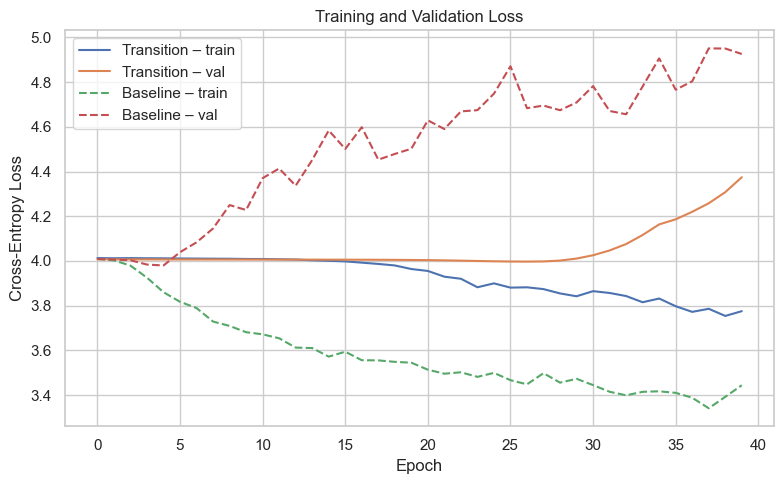

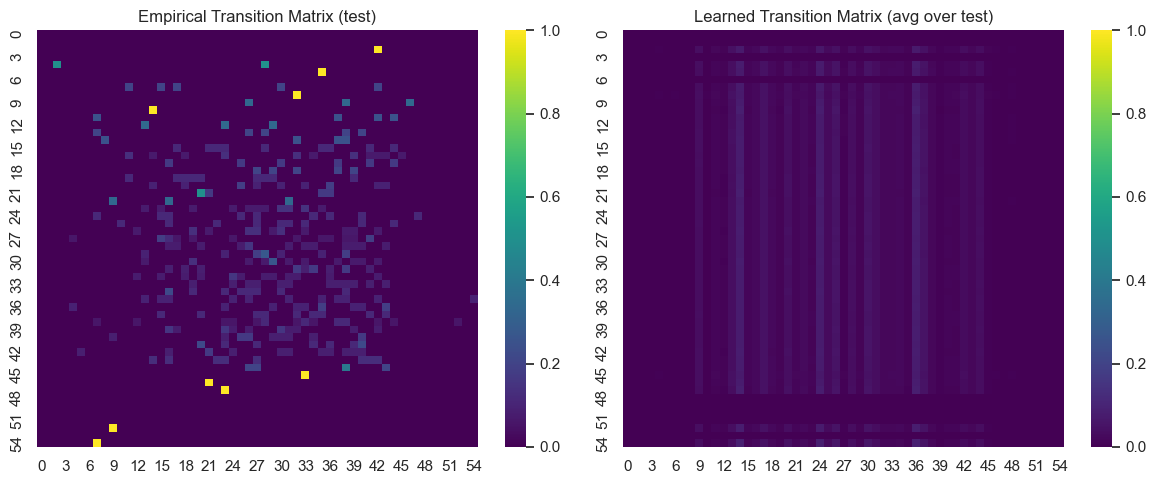

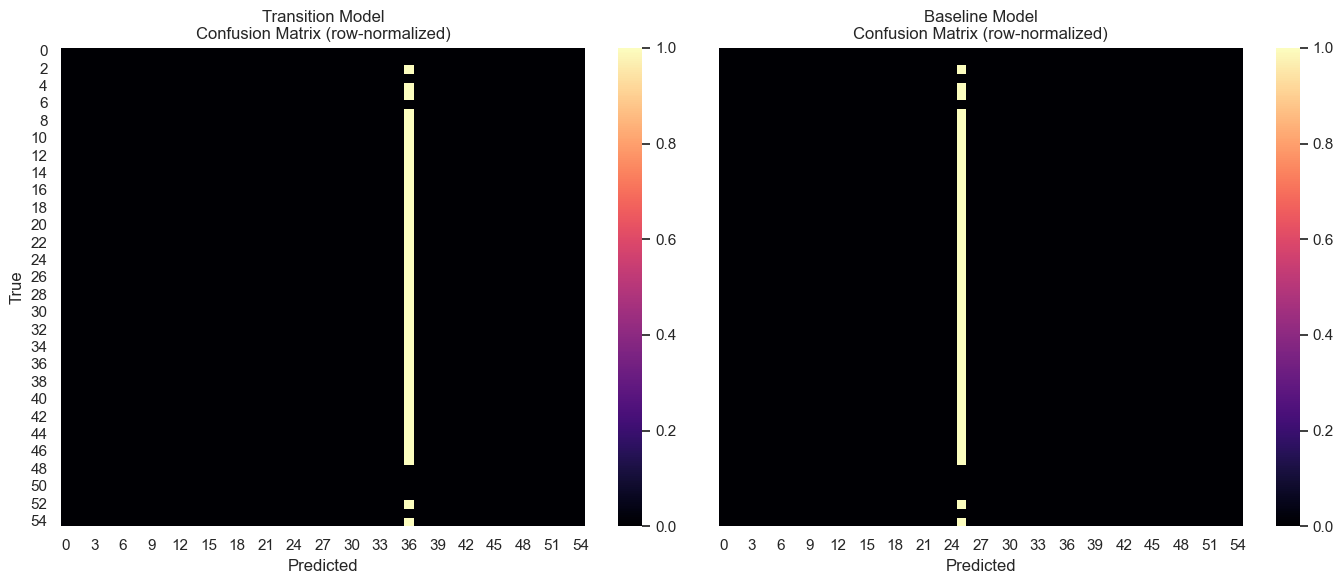

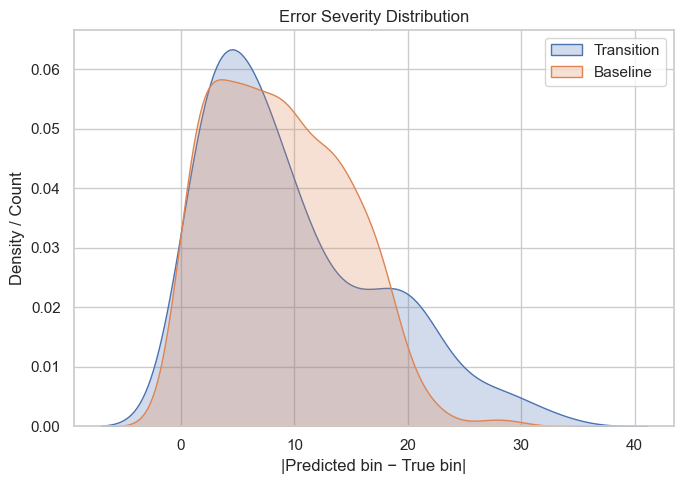

c:\Users\frede\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


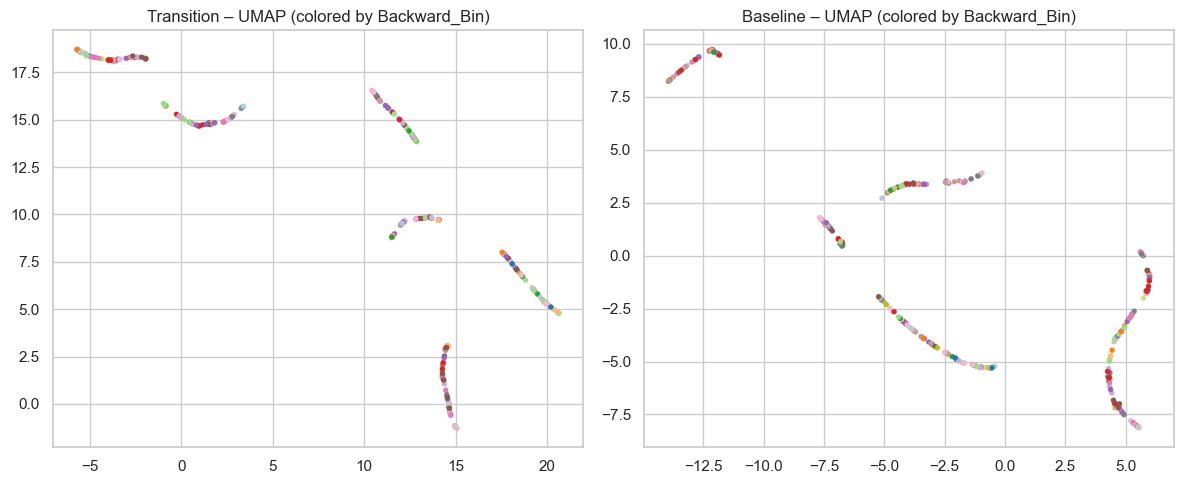

Test N: 356
Transition acc: 0.03089887640449438
Baseline acc: 0.025280898876404494


In [18]:
# ============================
# FINAL DIAGNOSTIC PLOTS (1–5)
# Paste this as ONE cell at the end
# ============================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F

sns.set(style="whitegrid")

# ----------------------------
# (0) Make sure model names exist
# ----------------------------
transition_model = model
baseline_model   = baseline

# ----------------------------
# (0.5) Auto-alias loss history names (safe)
# ----------------------------
g = globals()
items = list(g.items())  # IMPORTANT: freeze globals to avoid "dictionary changed size" error

def _pick(*names):
    for n in names:
        if n in g:
            return g[n]
    return None

train_losses_transition = _pick("train_losses_transition", "train_losses", "train_loss_list", "train_losses_model")
val_losses_transition   = _pick("val_losses_transition",   "val_losses",   "val_loss_list",   "val_losses_model")

train_losses_baseline   = _pick("train_losses_baseline", "baseline_train_losses", "train_losses_b", "baseline_train_loss_list")
val_losses_baseline     = _pick("val_losses_baseline",   "baseline_val_losses",   "val_losses_b",   "baseline_val_loss_list")

# Fallback: search for lists by name (SAFE iteration)
if train_losses_baseline is None:
    for k, v in items:
        if isinstance(v, list) and ("baseline" in k.lower()) and ("train" in k.lower()) and ("loss" in k.lower()):
            train_losses_baseline = v
            break

if val_losses_baseline is None:
    for k, v in items:
        if isinstance(v, list) and ("baseline" in k.lower()) and ("val" in k.lower()) and ("loss" in k.lower()):
            val_losses_baseline = v
            break

print("Loss lists found:",
      "\n  transition train:", type(train_losses_transition), "len:", (len(train_losses_transition) if isinstance(train_losses_transition, list) else None),
      "\n  transition val:  ", type(val_losses_transition),   "len:", (len(val_losses_transition) if isinstance(val_losses_transition, list) else None),
      "\n  baseline train:  ", type(train_losses_baseline),    "len:", (len(train_losses_baseline) if isinstance(train_losses_baseline, list) else None),
      "\n  baseline val:    ", type(val_losses_baseline),      "len:", (len(val_losses_baseline) if isinstance(val_losses_baseline, list) else None)
)

# ----------------------------
# UMAP import (robust) + fallback
# ----------------------------
try:
    import umap
    UMAP = umap.UMAP
except Exception:
    from sklearn.manifold import TSNE
    UMAP = None
    print("umap-learn not installed; using t-SNE for plot (5).")


# --------------------------------------------------
# Helper: collect predictions/labels from a loader
# --------------------------------------------------
def collect_from_loader(model, loader, device):
    model.eval()
    all_logits, all_y, all_s = [], [], []
    with torch.no_grad():
        for x, s_prev, y in loader:
            x = x.to(device); s_prev = s_prev.to(device); y = y.to(device)
            logits = model(x, s_prev)  # baseline ignores s_prev internally
            all_logits.append(logits.cpu())
            all_y.append(y.cpu())
            all_s.append(s_prev.cpu())

    logits = torch.cat(all_logits, dim=0)
    y = torch.cat(all_y, dim=0).numpy()
    s = torch.cat(all_s, dim=0).numpy()
    pred = logits.argmax(dim=1).numpy()
    probs = F.softmax(logits, dim=1).numpy()
    return probs, pred, y, s


def safe_row_normalize(M):
    M = M.astype(np.float64)
    rs = M.sum(axis=1, keepdims=True)
    return np.divide(M, rs, out=np.zeros_like(M), where=(rs != 0))


def confusion_matrix(pred, true, n_classes):
    cm = np.zeros((n_classes, n_classes), dtype=np.int64)
    for p, t in zip(pred, true):
        cm[int(t), int(p)] += 1
    return cm


# --------------------------------------------------
# (A) Collect arrays from test set
# Requires: test_loader, device, n_states
# --------------------------------------------------
probs_t, y_pred_transition, y_test, y_prev_test = collect_from_loader(transition_model, test_loader, device)
probs_b, y_pred_baseline,   _,      _          = collect_from_loader(baseline_model,   test_loader, device)

cm_transition = confusion_matrix(y_pred_transition, y_test, n_states)
cm_baseline   = confusion_matrix(y_pred_baseline,   y_test, n_states)

# --------------------------------------------------
# 1) Train / Val Loss Curves
# --------------------------------------------------
if isinstance(train_losses_transition, list) and isinstance(val_losses_transition, list) and \
   isinstance(train_losses_baseline, list)   and isinstance(val_losses_baseline, list):
    plt.figure(figsize=(8,5))
    plt.plot(train_losses_transition, label="Transition – train")
    plt.plot(val_losses_transition,   label="Transition – val")
    plt.plot(train_losses_baseline,   "--", label="Baseline – train")
    plt.plot(val_losses_baseline,     "--", label="Baseline – val")
    plt.xlabel("Epoch")
    plt.ylabel("Cross-Entropy Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Skipping Plot (1): could not find all loss history lists in globals().")


# --------------------------------------------------
# 2) Empirical vs Learned Transition Matrix
# --------------------------------------------------
empirical_tm = np.zeros((n_states, n_states), dtype=np.float64)
for s_prev, s_next in zip(y_prev_test, y_test):
    empirical_tm[int(s_prev), int(s_next)] += 1
empirical_tm = safe_row_normalize(empirical_tm)

learned_tm = np.zeros((n_states, n_states), dtype=np.float64)
counts = np.zeros((n_states,), dtype=np.int64)
for p_row, s_prev in zip(probs_t, y_prev_test):
    learned_tm[int(s_prev)] += p_row
    counts[int(s_prev)] += 1

for s in range(n_states):
    if counts[s] > 0:
        learned_tm[s] /= counts[s]
learned_tm = safe_row_normalize(learned_tm)

vmax = max(empirical_tm.max(), learned_tm.max())
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.heatmap(empirical_tm, ax=axes[0], cmap="viridis", vmin=0, vmax=vmax, cbar=True)
axes[0].set_title("Empirical Transition Matrix (test)")
sns.heatmap(learned_tm, ax=axes[1], cmap="viridis", vmin=0, vmax=vmax, cbar=True)
axes[1].set_title("Learned Transition Matrix (avg over test)")
plt.tight_layout()
plt.show()


# --------------------------------------------------
# 3) Normalized Confusion Matrices
# --------------------------------------------------
# --------------------------------------------------
# 3) Normalized Confusion Matrices (side by side)
# --------------------------------------------------
def normalize_rows(cm):
    cm = cm.astype(float)
    row_sums = cm.sum(axis=1, keepdims=True)
    return np.divide(cm, row_sums, out=np.zeros_like(cm), where=row_sums != 0)

cm_transition_norm = normalize_rows(cm_transition)
cm_baseline_norm   = normalize_rows(cm_baseline)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

sns.heatmap(
    cm_transition_norm,
    ax=axes[0],
    cmap="magma",
    cbar=True,
    vmin=0,
    vmax=1
)
axes[0].set_title("Transition Model\nConfusion Matrix (row-normalized)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(
    cm_baseline_norm,
    ax=axes[1],
    cmap="magma",
    cbar=True,
    vmin=0,
    vmax=1
)
axes[1].set_title("Baseline Model\nConfusion Matrix (row-normalized)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()



# --------------------------------------------------
# 4) Error Severity: |pred − true|
# --------------------------------------------------
err_transition = np.abs(y_pred_transition - y_test)
err_baseline   = np.abs(y_pred_baseline   - y_test)

plt.figure(figsize=(7,5))
try:
    sns.kdeplot(err_transition, label="Transition", fill=True)
    sns.kdeplot(err_baseline,   label="Baseline",   fill=True)
except Exception:
    plt.hist(err_transition, bins=30, alpha=0.6, label="Transition")
    plt.hist(err_baseline,   bins=30, alpha=0.6, label="Baseline")
plt.xlabel("|Predicted bin − True bin|")
plt.ylabel("Density / Count")
plt.title("Error Severity Distribution")
plt.legend()
plt.tight_layout()
plt.show()


# --------------------------------------------------
# 5) UMAP / t-SNE of Hidden Representations
# --------------------------------------------------
def extract_embeddings(model, loader, device, use_state):
    model.eval()
    Z, C = [], []
    with torch.no_grad():
        for x, s_prev, _ in loader:
            x = x.to(device); s_prev = s_prev.to(device)
            if use_state:
                z_in = torch.cat([x, F.one_hot(s_prev, num_classes=n_states).float()], dim=1)
                z = model.mlp(z_in)
            else:
                z = model.mlp(x)
            Z.append(z.cpu().numpy())
            C.append(s_prev.cpu().numpy())
    return np.vstack(Z), np.hstack(C)

Z_trans, C_trans = extract_embeddings(transition_model, test_loader, device, use_state=True)
Z_base,  C_base  = extract_embeddings(baseline_model,   test_loader, device, use_state=False)

Z_all = np.vstack([Z_trans, Z_base])

if UMAP is not None:
    reducer = UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    E_all = reducer.fit_transform(Z_all)
    title_suffix = "UMAP"
else:
    from sklearn.manifold import TSNE
    E_all = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(Z_all)
    title_suffix = "t-SNE"

Zt_2d = E_all[:len(Z_trans)]
Zb_2d = E_all[len(Z_trans):]

fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].scatter(Zt_2d[:,0], Zt_2d[:,1], c=C_trans, s=8, cmap="tab20")
axes[0].set_title(f"Transition – {title_suffix} (colored by Backward_Bin)")
axes[1].scatter(Zb_2d[:,0], Zb_2d[:,1], c=C_base, s=8, cmap="tab20")
axes[1].set_title(f"Baseline – {title_suffix} (colored by Backward_Bin)")
plt.tight_layout()
plt.show()

print("Test N:", len(y_test))
print("Transition acc:", (y_pred_transition == y_test).mean())
print("Baseline acc:",   (y_pred_baseline   == y_test).mean())


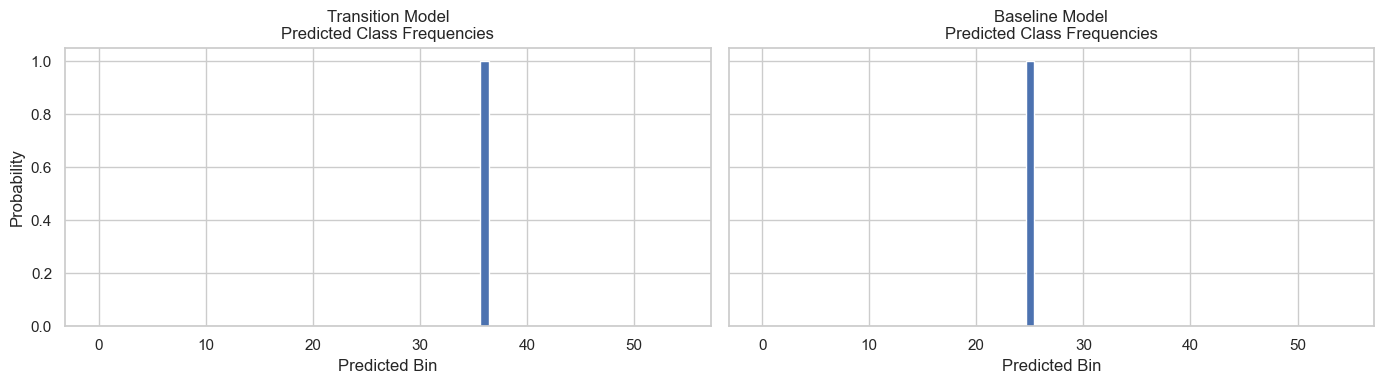

Transition dominant bin: 36
Baseline dominant bin:   25


In [19]:
# --------------------------------------------------
# Predicted Class Frequency Comparison
# --------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

# Count predicted bins
counts_transition = np.bincount(y_pred_transition, minlength=n_states)
counts_baseline   = np.bincount(y_pred_baseline,   minlength=n_states)

# Normalize to probabilities (optional but cleaner)
freq_transition = counts_transition / counts_transition.sum()
freq_baseline   = counts_baseline   / counts_baseline.sum()

bins = np.arange(n_states)

fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

axes[0].bar(bins, freq_transition)
axes[0].set_title("Transition Model\nPredicted Class Frequencies")
axes[0].set_xlabel("Predicted Bin")
axes[0].set_ylabel("Probability")

axes[1].bar(bins, freq_baseline)
axes[1].set_title("Baseline Model\nPredicted Class Frequencies")
axes[1].set_xlabel("Predicted Bin")

plt.tight_layout()
plt.show()

# Print dominant bins (helps interpretation)
print("Transition dominant bin:", np.argmax(freq_transition))
print("Baseline dominant bin:  ", np.argmax(freq_baseline))
